In [1]:
import inspect
import math
import os
import warnings

#import arviz as az

import jax.numpy as jnp
from jax import lax, ops, random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO, init_to_value, Predictive
from numpyro.infer.autoguide import AutoLaplaceApproximation

import arviz

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import beta
%matplotlib inline

## A second baseball example

In this examaple, we are interested in looking at what baseball shrinkage estimates look like when using a GLM vs a beta binomial model used previously.

In [2]:
from numpyro.examples.datasets import BASEBALL, load_dataset

In [3]:
_, fetch_train = load_dataset(BASEBALL, split='train', shuffle=False)
train, player_names = fetch_train()
_, fetch_test = load_dataset(BASEBALL, split='test', shuffle=False)
test, _ = fetch_test()
at_bats, hits = train[:, 0], train[:, 1]
season_at_bats, season_hits = test[:, 0], test[:, 1]

In [83]:
def partially_pooled_with_logit(at_bats, hits=None):
    r"""
    Number of hits has a Binomial distribution with a logit link function.
    The logits $\alpha$ for each player is normally distributed with the
    mean and scale parameters sharing a common prior.

    :param (jnp.DeviceArray) at_bats: Number of at bats for each player.
    :param (jnp.DeviceArray) hits: Number of hits for the given at bats.
    :return: Number of hits predicted by the model.
    """
    loc = numpyro.sample("loc", dist.Normal(-1, 1))
    scale = numpyro.sample("scale", dist.HalfCauchy(1))
    num_players = at_bats.shape[0]
    with numpyro.plate("num_players", num_players):
        alpha = numpyro.sample("alpha", dist.Normal(loc, scale))
        p = numpyro.deterministic("p", 1/(1 + jnp.exp(-alpha)))
        return numpyro.sample("obs", dist.Binomial(at_bats, logits=alpha), obs=hits)

In [84]:
training_rnd_key = random.PRNGKey(3)
chain = MCMC(NUTS(partially_pooled_with_logit), num_warmup=500, num_samples=2500, num_chains=1)

In [85]:
chain.run(training_rnd_key, at_bats=train[:,0], hits=train[:, 1])

sample: 100%|██████████| 3000/3000 [00:05<00:00, 527.25it/s, 15 steps of size 3.12e-01. acc. prob=0.73]


In [86]:
chain.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]     -0.88      0.20     -0.91     -1.19     -0.54    344.49      1.00
  alpha[1]     -0.90      0.19     -0.92     -1.19     -0.56    365.78      1.00
  alpha[2]     -0.93      0.18     -0.94     -1.20     -0.61    544.93      1.00
  alpha[3]     -0.95      0.18     -0.96     -1.26     -0.68    711.61      1.00
  alpha[4]     -0.97      0.18     -0.98     -1.25     -0.67    772.31      1.00
  alpha[5]     -0.98      0.17     -0.98     -1.26     -0.68    765.73      1.00
  alpha[6]     -1.00      0.17     -1.01     -1.29     -0.72    809.75      1.00
  alpha[7]     -1.03      0.17     -1.02     -1.29     -0.74    778.07      1.00
  alpha[8]     -1.05      0.18     -1.04     -1.35     -0.78    658.15      1.00
  alpha[9]     -1.05      0.18     -1.04     -1.35     -0.75    818.47      1.00
 alpha[10]     -1.08      0.18     -1.06     -1.37     -0.79    608.12      1.00
 alpha[11]     -1.07      0

Note the divergences! We see them mentioned for the frequentist way of partial pooling in [this article](https://towardsdatascience.com/when-mixed-effects-hierarchical-models-fail-pooling-and-uncertainty-77e667823ae8). What do these effects look like when looking at the confidence / credible intervals?

In [16]:
chain.get_samples()['p'].mean(axis=0)

DeviceArray([0.29460853, 0.2912023 , 0.28530136, 0.27954486, 0.27573085,
             0.27502915, 0.2703755 , 0.26511112, 0.2610254 , 0.26074883,
             0.25549757, 0.25717404, 0.2558762 , 0.25526947, 0.25571743,
             0.25002939, 0.24665901, 0.24119717], dtype=float32)

In [19]:
chain.get_samples()['p'].std(axis=0)

DeviceArray([0.04236243, 0.04052864, 0.03788842, 0.03692318, 0.03578113,
             0.03493963, 0.0342773 , 0.0329261 , 0.03382863, 0.03459041,
             0.03379739, 0.03390343, 0.03359025, 0.0324549 , 0.03368549,
             0.03399245, 0.03513052, 0.03705008], dtype=float32)

Numbers here actually look pretty reasonable

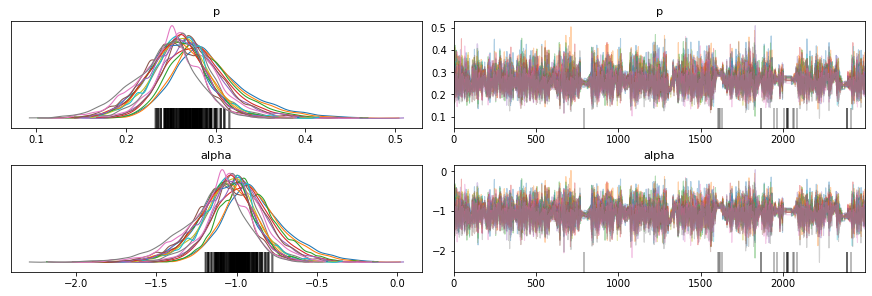

In [25]:
arviz.plot_trace(chain, var_names=["p", "alpha"]);

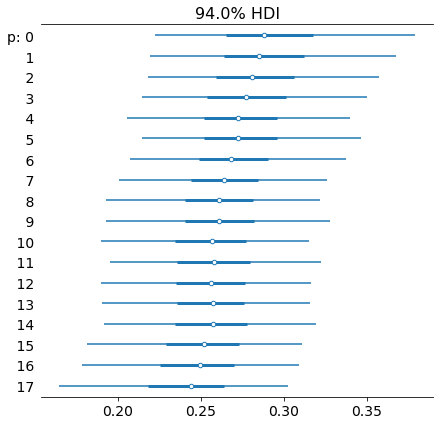

In [27]:
arviz.plot_forest(chain, var_names=["p"]);

## Comparison to empirical bayes

In [73]:
def fit_beta_binomial(at_bats, hits=None):
    alpha = numpyro.sample("alpha", dist.Exponential(0.001))
    beta = numpyro.sample("beta", dist.Exponential(0.001))
    p = numpyro.sample("p", dist.Beta(alpha, beta))
    return numpyro.sample("obs", dist.Binomial(at_bats, probs=p), obs=hits)
    

In [74]:
training_rnd_key = random.PRNGKey(3)
chain2 = MCMC(NUTS(fit_beta_binomial), num_warmup=500, num_samples=2500, num_chains=1)

In [75]:
chain2.run(training_rnd_key, at_bats=train[:,0], hits=train[:, 1])

sample: 100%|██████████| 3000/3000 [00:05<00:00, 504.22it/s, 63 steps of size 4.44e-02. acc. prob=0.93]  


In [76]:
chain2.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha    548.42    390.06    464.83     35.67   1026.44    615.29      1.00
      beta   1500.82   1060.72   1263.41     91.74   2830.62    611.34      1.00
         p      0.27      0.02      0.27      0.24      0.29    769.16      1.00

Number of divergences: 0


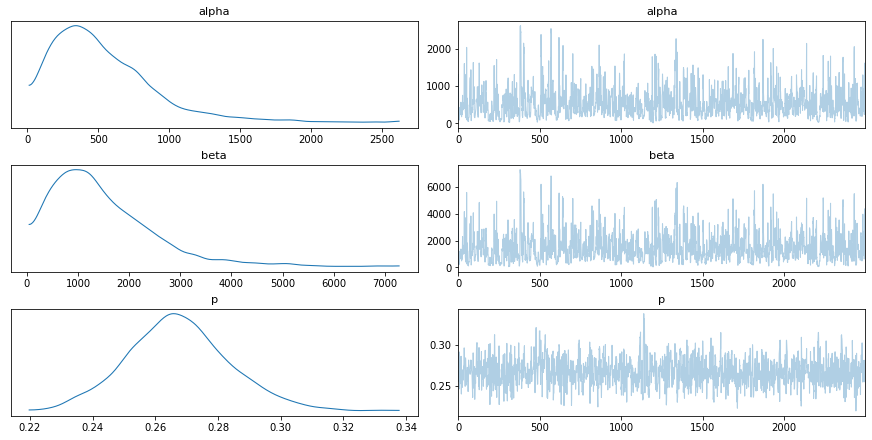

In [77]:
arviz.plot_trace(chain2);

In [78]:
alpha, beta = chain2.get_samples()['alpha'].mean(), chain2.get_samples()['beta'].mean()

In [79]:
alpha, beta

(DeviceArray(548.4222, dtype=float32), DeviceArray(1500.8214, dtype=float32))

In [80]:
alpha_vec = alpha + train[:, 1]
beta_vec = beta + (train[:, 0] - train[:, 1])

In [81]:
eb_point_est = alpha_vec/(alpha_vec + beta_vec)
logisitic_point_est = chain.get_samples()['p'].mean(axis=0)

Text(0, 0.5, 'logistic')

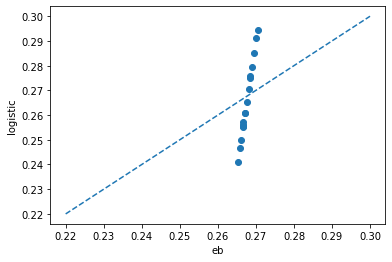

In [82]:
plt.scatter(eb_point_est, logisitic_point_est)
plt.plot([0.22, 0.3], [0.22,0.3], '--')
plt.xlabel('eb')
plt.ylabel('logistic')